<a href="https://colab.research.google.com/github/LoniQin/deep_learning_notebooks/blob/master/MINST_Classifier_using_Functional_API_and_Custom_Training_Loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNIST Classifier using Functional API and Custom Training method

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

## Load data

In [2]:
train_data, info = tfds.load("mnist", split="train", with_info=True, download=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
def formatter(data):
  image = data["image"]
  image = tf.cast(image, 'float32')
  image = image / 255.0
  label = data["label"]
  return image, label

In [4]:
train_data = train_data.map(formatter).shuffle(buffer_size=1024).batch(32)

## Build the Model

In [5]:
input = tf.keras.layers.Input(info.features['image'].shape)
x = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(info.features['label'].num_classes, name='output', activation='softmax')(x)
model = tf.keras.models.Model(inputs=input, outputs=output)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0     

## Create optimizer and loss object

In [7]:
optimzier = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()

## Custimize Train method

In [8]:
def train(model, dataset, loss, optimizer, epochs):
  losses = []
  for epoch in range(epochs):
    epoch_losses = []
    pbar = tqdm(total=len(list(enumerate(dataset))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    for step, (x, y) in enumerate(dataset):
      with tf.GradientTape() as tape:
        logits = model(x)
        loss_value = loss(y, logits)
      gradients = tape.gradient(loss_value, model.trainable_weights)
      optimizer.apply_gradients(zip(gradients, model.trainable_weights))
      epoch_losses.append(loss_value)
      pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
      pbar.update()
    losses.append(np.mean(epoch_losses))
  return losses

## Train the model

In [9]:
losses = train(model, train_data, loss, optimzier, epochs=10)

Training loss for step 1874: 0.0000: 100%|██████████| 1875/1875 

## Plot losses

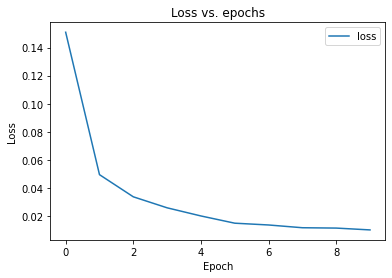

In [10]:
plt.plot(losses, label='loss')
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()